In [22]:
from helper_functions import *

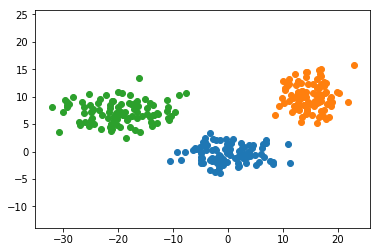

In [23]:
# Define 3 centres and 3 spreads for our distributions 
mu_1 = np.array([0, 0])
sigma_1 = np.array([[20, 0], [0, 3]])

mu_2 = np.array([15, 10])
sigma_2 = np.array([[7, 0], [0, 5]])

mu_3 = np.array([-20, 7])
sigma_3 = np.array([[30, 1], [1, 4]])

# Generate the pointcloud
pc_size = 100

pc_1 = np.random.multivariate_normal(mu_1, sigma_1, pc_size).T
pc_2 = np.random.multivariate_normal(mu_2, sigma_2, pc_size).T
pc_3 = np.random.multivariate_normal(mu_3, sigma_3, pc_size).T

# Plot the pointclouds
plt.axis('equal')
plt.scatter(pc_1[0], pc_1[1])
plt.scatter(pc_2[0], pc_2[1])
plt.scatter(pc_3[0], pc_3[1]);

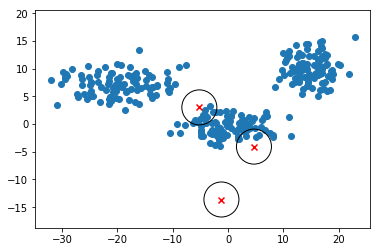

In [24]:
# Unify pointclouds
pc = np.concatenate((pc_1, pc_2, pc_3), axis=1)

# Mixture of Gaussians: we need K means, covariances and initial probabilities
K = 3
N = pc.shape[1]

mus = []
sigmas = []
pis = []

# Initialise the quantities
for k in range(K):
    mus.append((0.5 - np.random.rand(2, 1).flatten()) * 30)
    sigmas.append(np.eye(2) * 10)
    pis.append(1/K) # Uniform distribution on the Ks
    
def plot_state():
    # Plot what we have just now
    plt.scatter(pc[0], pc[1])

    for k in range(K):
        plt.scatter(mus[k][0], mus[k][1], c='r', marker='x')  
        plt.axis('equal')
        ell = get_normal_std_ellipse(mus[k], sigmas[k])
        plt.gca().add_artist(ell)
        
plot_state()

EM for MoG
--------------

For data $\{\mathbf{x}_n\}_{n = 1}^N$ and parameters $\theta (= \{\mu_{1..K}, \Sigma_{1..K}, \pi_{1..K}\})$, and probability density $p(\mathbf{x}_n \mid s_n = k, \theta)$ (here Gaussian) the free energy is:

$$
\mathcal{F}(q(s), \theta) = \log p(\{\mathbf{x}_n\}_{n = 1}^N \mid  \theta) - \sum_{\mathbf{s}} q(\mathbf{s}) \log\frac{q(\mathbf{s})}{p(\mathbf{s} \mid \{\mathbf{x}_n\}_{n = 1}^N, \theta)}
$$
where $q$ is an arbitrary density.

### E-step

During the E-step, we fix $\theta^*$ and optimise for $q(\mathbf{s})$. By Gibbs' Theorem, this happens when 

$$
q(s_n = k) = p(s_n = k \mid \mathbf{x}_n, \theta) = \frac{1}{p(\mathbf{x}_n \mid \theta)}p(\mathbf{x}_n \mid s_n = k, \theta)p(s_n = k) \propto p(\mathbf{x}_n \mid s_n = k, \theta)p(s_n = k)
$$

So, given that 

$$ 
p(\mathbf{x}_n \mid s_n = k, \theta) = \mathcal{N}(\mathbf{x}_n; \mu_k, \Sigma_k)
$$ 

and

$$
p(s_n = k) = \pi_k
$$

We get 

$$
u_{n,k} = \frac{\pi_k}{\sqrt{\det(2\pi \Sigma_k)}}\exp\{\frac{1}{2}(\mathbf{x}_n - \mu_k)^T \Sigma^{-1}_k (\mathbf{x}_n - \mu_k) \}
$$

which is the top bit in the equation above, and to get the normalising term, we calculate

$$
u_n = p(\mathbf{x}_n \mid \theta) = \sum_{k = 1}^K p(\mathbf{x}_n, s_n = k \mid \theta) = \sum_{k = 1}^K u_{n, k}
$$

And thus finally put

$$
q(s_n = k) = \frac{u_{n,k}}{u_n}
$$

### M-step

During the M-step, we fix $q(\mathbf{s})$ and optimise for $\theta$.

It can be shown that the free energy can be written in the following form:

$$
\mathcal{F}(q(s), \theta) = \mathbb{E}_q[\log{p(\mathbf{s}, \{\mathbf{x}_n\}_{n = 1}^N \mid \theta)}] - \mathbb{E}_q[\log q(\mathbf{s}) ]
$$

Since the second expectation doesn't depend on $\theta$, in the M-step, we just maximise $\mathbb{E}_q[\log{p(\mathbf{s}, \{\mathbf{x}_n\}_{n = 1}^N \mid \theta)}]$:



In [25]:
# E-step

def e_step():
    # Set up the probability matrix
    q = np.zeros((N, K))

    # Calculate the inverses of the covariance matrices
    siginvs = [np.linalg.inv(sigma) for sigma in sigmas]

    # define log(u_n,k)
    def u(n, k):
        sub_n_k = pc[:, n] - mus[k]
        return np.log(pis[k]) - 0.5 * np.linalg.det(2 * np.pi * sigmas[k]) - 0.5 * np.dot(np.dot(sub_n_k.T, siginvs[k]), sub_n_k) 

    for n in range(N):
        for k in range(K):
            q[n, k] = u(n, k)

        # Make use of the fact that e^x / e^x + e^y + ... = 1 / 1 + e^{y - x} + ... for numeric stability
        q[n, :] = np.exp(q[n, :] - q[n, 0])

        u_n = np.sum(q[n, :])

        q[n, :] = q[n, :] / u_n
        
    return q
        
q = e_step()

In [26]:
# M-step
def m_step(q):
    global mus, sigmas, pis
    
    for k in range(K):
        prob_sum = np.sum(q[:, k])

        mus[k] = np.dot(pc, q[:, k].T) / prob_sum

        sigma = np.zeros(sigmas[k].shape)

        for n in range(N):
            sigma += q[n, k] * np.outer((pc[:, n].T - mus[k]), (pc[:, n].T - mus[k]))

        sigmas[k] = sigma / prob_sum

        pis[k] = 1 / N * prob_sum
        
m_step(q)

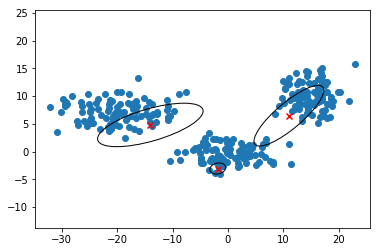

In [27]:
plot_state()

In [28]:
import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Click Me!")
display(button)

def iterate_em(b):
    q = e_step()
    m_step(q)
    plot_state()

button.on_click(iterate_em)

Button(description='Click Me!', style=ButtonStyle())